# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
# Install keras
%pip install keras
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'f:\Shadman\advanced-nlp-with-python-for-machine-learning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'f:\Shadman\advanced-nlp-with-python-for-machine-learning\venv\Scripts\python.exe -m pip install --upgrade pip' command.



  Using cached wrapt-1.14.1-cp37-cp37m-win_amd64.whl (35 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.7.0-cp37-cp37m-win_amd64.whl (2.6 MB)
  Using cached absl_py-1.2.0-py3-none-any.whl (123 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached Markdown-3.4.1-py3-none-any.whl (93 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached cachetools-5.2.

In [7]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [8]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [9]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [10]:
# What do these sequences look like?
X_train_seq[0]

[195,
 100,
 17,
 2017,
 46,
 13,
 358,
 13,
 804,
 43,
 2566,
 1122,
 931,
 1123,
 257,
 26,
 321,
 152,
 518,
 434,
 1672,
 1124,
 496,
 173,
 290,
 2018,
 1466,
 3807]

In [16]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [17]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        195,  100,   17, 2017,   46,   13,  358,   13,  804,   43, 2566,
       1122,  931, 1123,  257,   26,  321,  152,  518,  434, 1672, 1124,
        496,  173,  290, 2018, 1466, 3807])

### Build Model

In [13]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [14]:
# Construct a simple RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          255040    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [18]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 12s 39ms/step - loss: 0.2421 - accuracy: 0.9230 - precision_m: 0.5095 - recall_m: 0.4380 - val_loss: 0.0646 - val_accuracy: 0.9803 - val_precision_m: 0.9086 - val_recall_m: 0.8003
Epoch 2/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0370 - accuracy: 0.9897 - precision_m: 0.9539 - recall_m: 0.9260 - val_loss: 0.0336 - val_accuracy: 0.9883 - val_precision_m: 0.8967 - val_recall_m: 0.8720
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0144 - accuracy: 0.9964 - precision_m: 0.9893 - recall_m: 0.9674 - val_loss: 0.0363 - val_accuracy: 0.9892 - val_precision_m: 0.9086 - val_recall_m: 0.8577
Epoch 4/10
140/140 [==============================] - 4s 28ms/step - loss: 0.0050 - accuracy: 0.9991 - precision_m: 0.9847 - recall_m: 0.9813 - val_loss: 0.0338 - val_accuracy: 0.9910 - val_precision_m: 0.9086 - val_recall_m: 0.8720
Epoch 5/10
140/140 [==============================] - 4s 28ms/step 

You should consider upgrading via the 'f:\Shadman\advanced-nlp-with-python-for-machine-learning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.2.0-cp37-cp37m-win_amd64.whl (3.3 MB)
  Using cached kiwisolver-1.4.4-cp37-cp37m-win_amd64.whl (54 kB)
Note: you may need to restart the kernel to use updated packages.


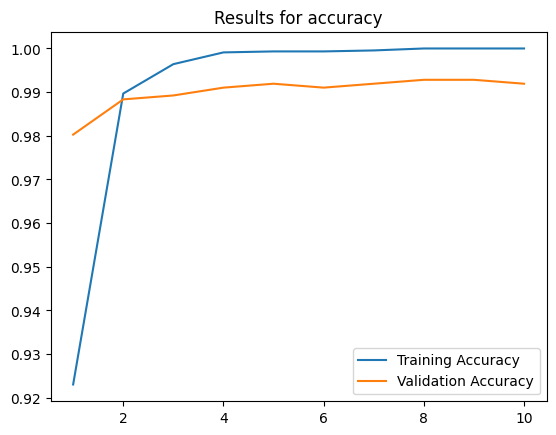

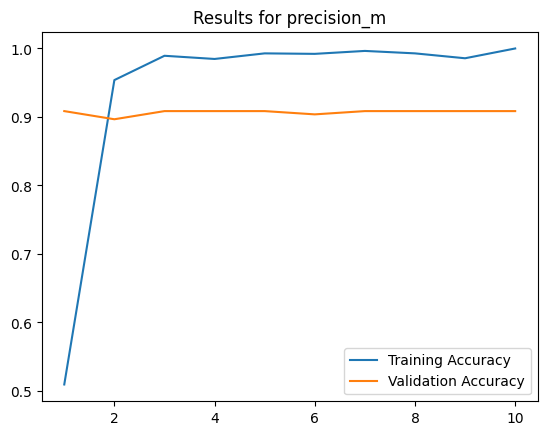

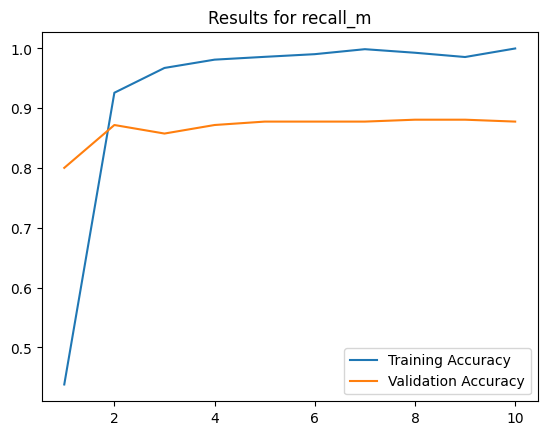

In [19]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
%pip install matplotlib
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()